## Imports

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import ConcatDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import importlib

### Loading Repo

In [2]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

fatal: destination path 'ATML-PA-2' already exists and is not an empty directory.


In [26]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 931 bytes | 186.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Updating 45013d6..c1bb656
Fast-forward
 DANN & CDAN/CDAN.py |  9 +++++----
 DANN & CDAN/DANN.py | 13 ++++++-------
 2 files changed, 11 insertions(+), 11 deletions(-)


In [4]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2


In [6]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN


In [7]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  __pycache__  train.py  utils


In [8]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [9]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [10]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])


In [ ]:
# transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [11]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, train_transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, test_transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [12]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [13]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [21]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


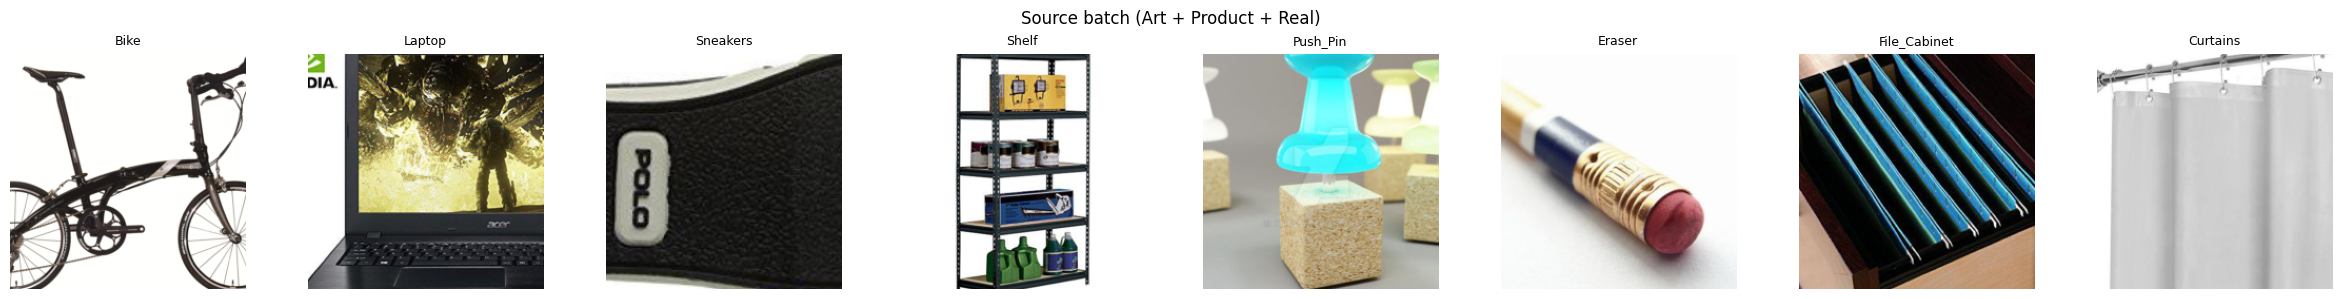

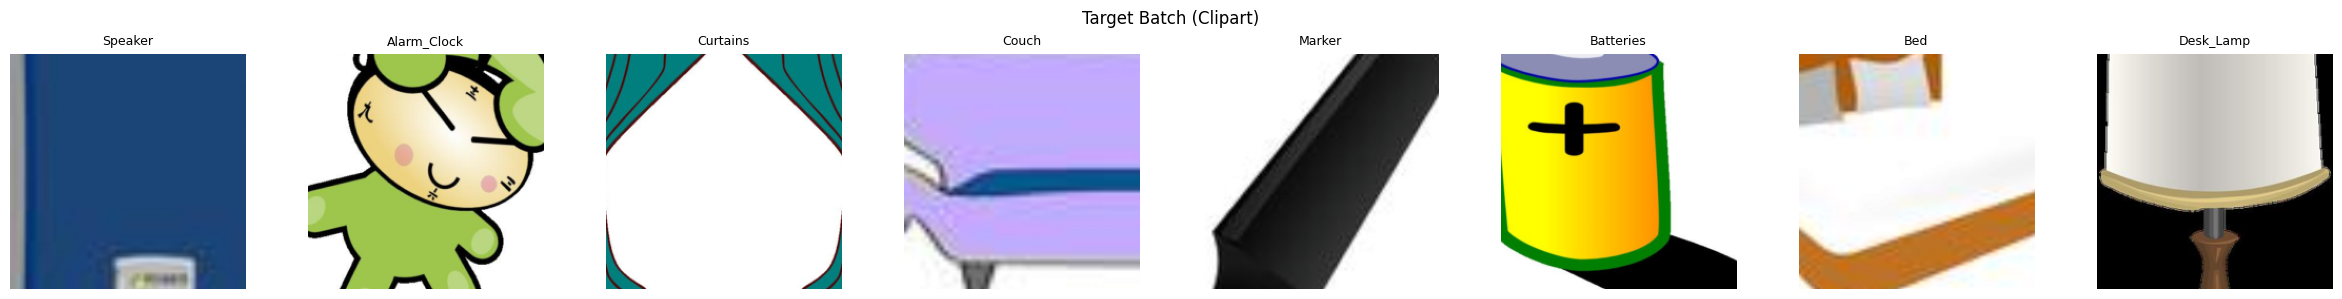

In [23]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## DANN Training

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
import DANN as dann
importlib.reload(dann)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [16]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50

In [17]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [18]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [28]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [20]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:18<00:00,  7.61it/s]


In [29]:
rest = truncate_from(base_resnet, 'layer3')
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)

In [30]:
model = dann.DANN(num_classes=65, resnet=rest_wrapper)

In [31]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [32]:
trainer = dann.DANNTrainer(
        model=model,
        device=device,
        learning_rate=1e-4,
        weight_decay=5e-4,
        gamma=5.0
    )

In [33]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 351/351 [00:36<00:00,  9.65it/s, cls_loss=1.1386, dom_loss=1.3695, cls_acc=0.7391, alpha=0.0000]
                                                                    

Epoch 1/10 - Train Loss: 4.5531, Train Acc: 0.6241, Target Loss: 2.2891, Target Acc: 0.4573


Epoch 2/10: 100%|██████████| 351/351 [00:37<00:00,  9.36it/s, cls_loss=0.4557, dom_loss=1.4269, cls_acc=0.8261, alpha=0.2449]
                                                                    

Epoch 2/10 - Train Loss: 3.2749, Train Acc: 0.8597, Target Loss: 2.3037, Target Acc: 0.4674


Epoch 3/10: 100%|██████████| 351/351 [00:38<00:00,  9.20it/s, cls_loss=0.2758, dom_loss=1.3724, cls_acc=0.9565, alpha=0.4621]
                                                                    

Epoch 3/10 - Train Loss: 3.0020, Train Acc: 0.9398, Target Loss: 2.5602, Target Acc: 0.4834


Epoch 4/10: 100%|██████████| 351/351 [00:38<00:00,  9.11it/s, cls_loss=0.0604, dom_loss=1.3481, cls_acc=1.0000, alpha=0.6351]
                                                                    

Epoch 4/10 - Train Loss: 2.8905, Train Acc: 0.9768, Target Loss: 2.7759, Target Acc: 0.4756


Epoch 5/10: 100%|██████████| 351/351 [00:38<00:00,  9.09it/s, cls_loss=0.0361, dom_loss=1.4006, cls_acc=1.0000, alpha=0.7616]
                                                                    

Epoch 5/10 - Train Loss: 2.8639, Train Acc: 0.9819, Target Loss: 2.7478, Target Acc: 0.4855


Epoch 6/10: 100%|██████████| 351/351 [00:39<00:00,  8.98it/s, cls_loss=0.1549, dom_loss=1.3764, cls_acc=0.9130, alpha=0.8483]
                                                                    

Epoch 6/10 - Train Loss: 2.8406, Train Acc: 0.9862, Target Loss: 2.8648, Target Acc: 0.4857


Epoch 7/10: 100%|██████████| 351/351 [00:39<00:00,  8.87it/s, cls_loss=0.0397, dom_loss=1.3912, cls_acc=1.0000, alpha=0.9051]
                                                                    

Epoch 7/10 - Train Loss: 2.8424, Train Acc: 0.9866, Target Loss: 3.1112, Target Acc: 0.4674


Epoch 8/10: 100%|██████████| 351/351 [00:40<00:00,  8.67it/s, cls_loss=0.0415, dom_loss=1.3840, cls_acc=1.0000, alpha=0.9414]
                                                                    

Epoch 8/10 - Train Loss: 2.8510, Train Acc: 0.9816, Target Loss: 3.1514, Target Acc: 0.4754


Epoch 9/10: 100%|██████████| 351/351 [00:38<00:00,  9.00it/s, cls_loss=0.0594, dom_loss=1.4066, cls_acc=1.0000, alpha=0.9640]
                                                                    

Epoch 9/10 - Train Loss: 2.8369, Train Acc: 0.9851, Target Loss: 3.1861, Target Acc: 0.4600


Epoch 10/10: 100%|██████████| 351/351 [00:40<00:00,  8.72it/s, cls_loss=0.1252, dom_loss=1.3617, cls_acc=0.9130, alpha=0.9780]


Epoch 10/10 - Train Loss: 2.8295, Train Acc: 0.9888, Target Loss: 3.1351, Target Acc: 0.4905



=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     1.0000    1.0000    1.0000       239
    Backpack     1.0000    1.0000    1.0000       239
   Batteries     1.0000    1.0000    1.0000       153
         Bed     1.0000    1.0000    1.0000       166
        Bike     1.0000    1.0000    1.0000       218
      Bottle     0.8885    1.0000    0.9409       239
      Bucket     1.0000    1.0000    1.0000       167
  Calculator     0.9212    1.0000    0.9590       187
    Calendar     1.0000    0.9882    0.9940       169
     Candles     0.9957    1.0000    0.9978       231
       Chair     1.0000    0.9962    0.9981       264
  Clipboards     1.0000    1.0000    1.0000       155
    Computer     0.9528    0.9902    0.9712       204
       Couch     1.0000    1.0000    1.0000       204
    Curtains     1.0000    1.0000    1.0000       188
   Desk_Lamp     0.9882    1.0000    0.9941       168
       Drill     1.0000    1.0000    1.0000       133
    

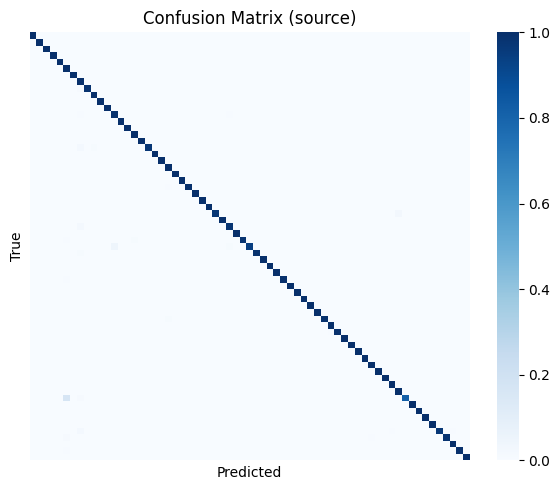

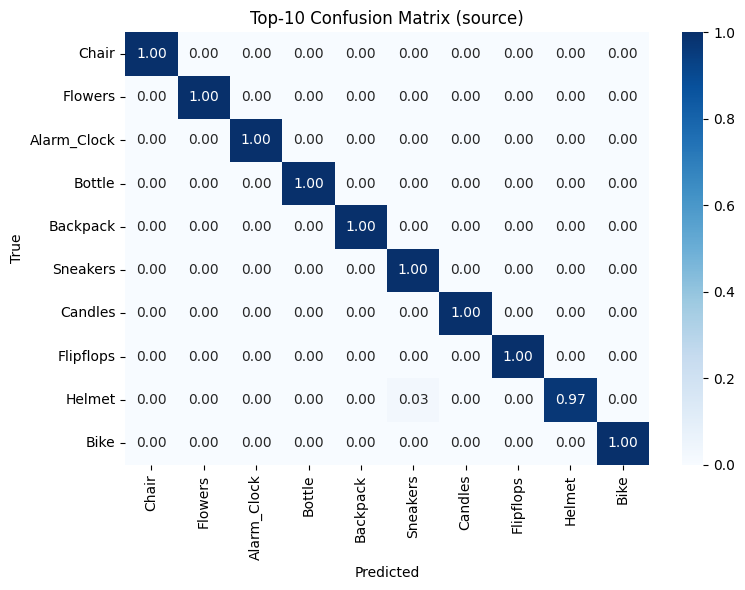


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.7049    0.7167    0.7107        60
    Backpack     0.6429    0.4821    0.5510        56
   Batteries     0.4643    0.4062    0.4333        64
         Bed     0.5294    0.2755    0.3624        98
        Bike     0.9101    0.8182    0.8617        99
      Bottle     0.3014    0.4444    0.3592        99
      Bucket     0.5636    0.4247    0.4844        73
  Calculator     0.2821    0.9565    0.4356        46
    Calendar     0.5067    0.4872    0.4967        78
     Candles     0.4359    0.3434    0.3842        99
       Chair     0.7083    0.5152    0.5965        99
  Clipboards     0.2000    0.1000    0.1333        40
    Computer     0.3864    0.3434    0.3636        99
       Couch     0.2986    0.6719    0.4135        64
    Curtains     0.9143    0.7619    0.8312        42
   Desk_Lamp     0.1475    0.2195    0.1765        41
       Drill     0.5581    0.5000    0.5275        48
    

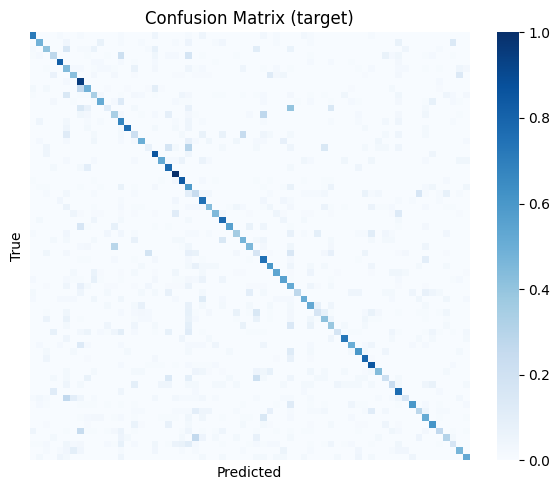

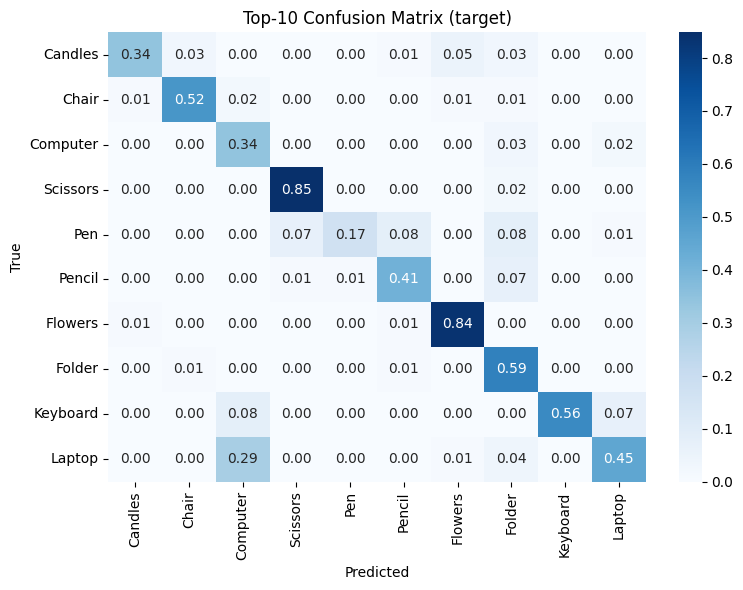

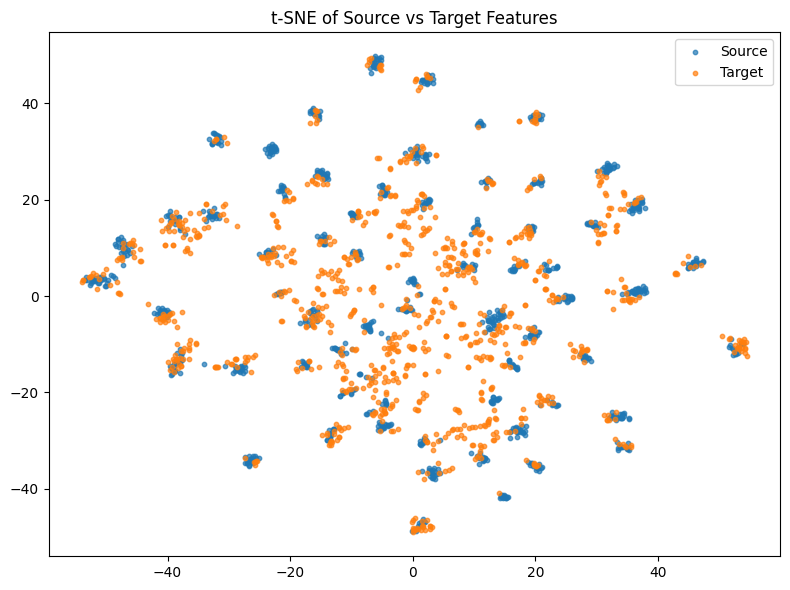

{'tsne': array([[ -7.5368605,  -5.9746876],
        [-27.030317 , -34.73741  ],
        [ -5.023402 ,  23.019754 ],
        ...,
        [-14.922599 ,  11.34326  ],
        [ -6.074972 , -24.228546 ],
        [ -1.6445595,  17.616295 ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     1.0000    1.0000    1.0000       239\n    Backpack     1.0000    1.0000    1.0000       239\n   Batteries     1.0000    1.0000    1.0000       153\n         Bed     1.0000    1.0000    1.0000       166\n        Bike     1.0000    1.0000    1.0000       218\n      Bottle     0.8885    1.0000    0.9409       239\n      Bucket     1.0000    1.0000    1.0000       167\n  Calculator     0.9212    1.0000    0.9590       187\n    Calendar     1.0000    0.9882    0.9940       169\n     Candles     0.9957    1.0000    0.9978       231\n       Chair     1.0000    0.9962    0.9981       264\n  Clipboards     1.0000    1.0000    1.0000       155\n    Co

: 

In [ ]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)